In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [3]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


50 50


In [4]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0


for k in train_ind:
    rad = f"{k:.2f}"
    traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
    train.append(traindf)
    recover_train.append((rad,traincnt,len(traindf)))
    traincnt+=1
        
for l in test_ind:
    rad = f"{l:.2f}"
    testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
    test.append(testdf)                    
    recover_test.append((rad,testcnt,len(testdf)))
    testcnt+=1

In [5]:
rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': 'h$_{p}^{0}$',
'h$_{pp}^{1}$': 'h$_{p}^{1}$',
'h$_{pp}^{2}$': 'h$_{p}^{2}$',
'h$_{pp}^{3}$': 'h$_{p}^{3}$',
'h$_{rr}^{0}$': 'h$_{r}^{0}$',
'h$_{rr}^{1}$': 'h$_{r}^{1}$',
'h$_{rr}^{2}$': 'h$_{r}^{2}$',
'h$_{rr}^{3}$': 'h$_{r}^{3}$'}

In [6]:
train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)

In [7]:
X_train = train_df.drop(columns=['Pair_Energies']).values
X_test = test_df.drop(columns=['Pair_Energies']).values

y_train = train_df['Pair_Energies'].values
y_test = test_df['Pair_Energies'].values

In [8]:
X_train.shape

(20800, 105)

In [9]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

{'objective': 'reg:squarederror',
 'enable_categorical': False,
 'max_depth': 10,
 'n_estimators': 1000,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001}

In [15]:
from xgboost import XGBRegressor

kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
model=XGBRegressor(**kwargs)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# params = {'max_depth': [1, 10, 100],
#           'n_estimators': [100, 500, 1000],
#           'reg_lambda': [1e-6, 1e-3,1e-1],
#           'reg_alpha': [1e-6, 1e-3,1e-1]}

# model = XGBRegressor()
# grid = GridSearchCV(estimator=model, 
#                    param_grid=params,
#                    scoring='r2', 
#                    verbose=1000,n_jobs=12).fit(X_train,y_train)


# model=grid.best_estimator_
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

# pd.DataFrame.from_dict(model.get_params(),orient='index').dropna().to_excel("iron_VDZP_params.xlsx")


R2: 0.9726,0.9090
RMSE (mEh): 0.3180,0.5821


In [42]:
pal

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [16]:
try:
    os.mkdir('images')
except:
    print('./images exist')

./images exist


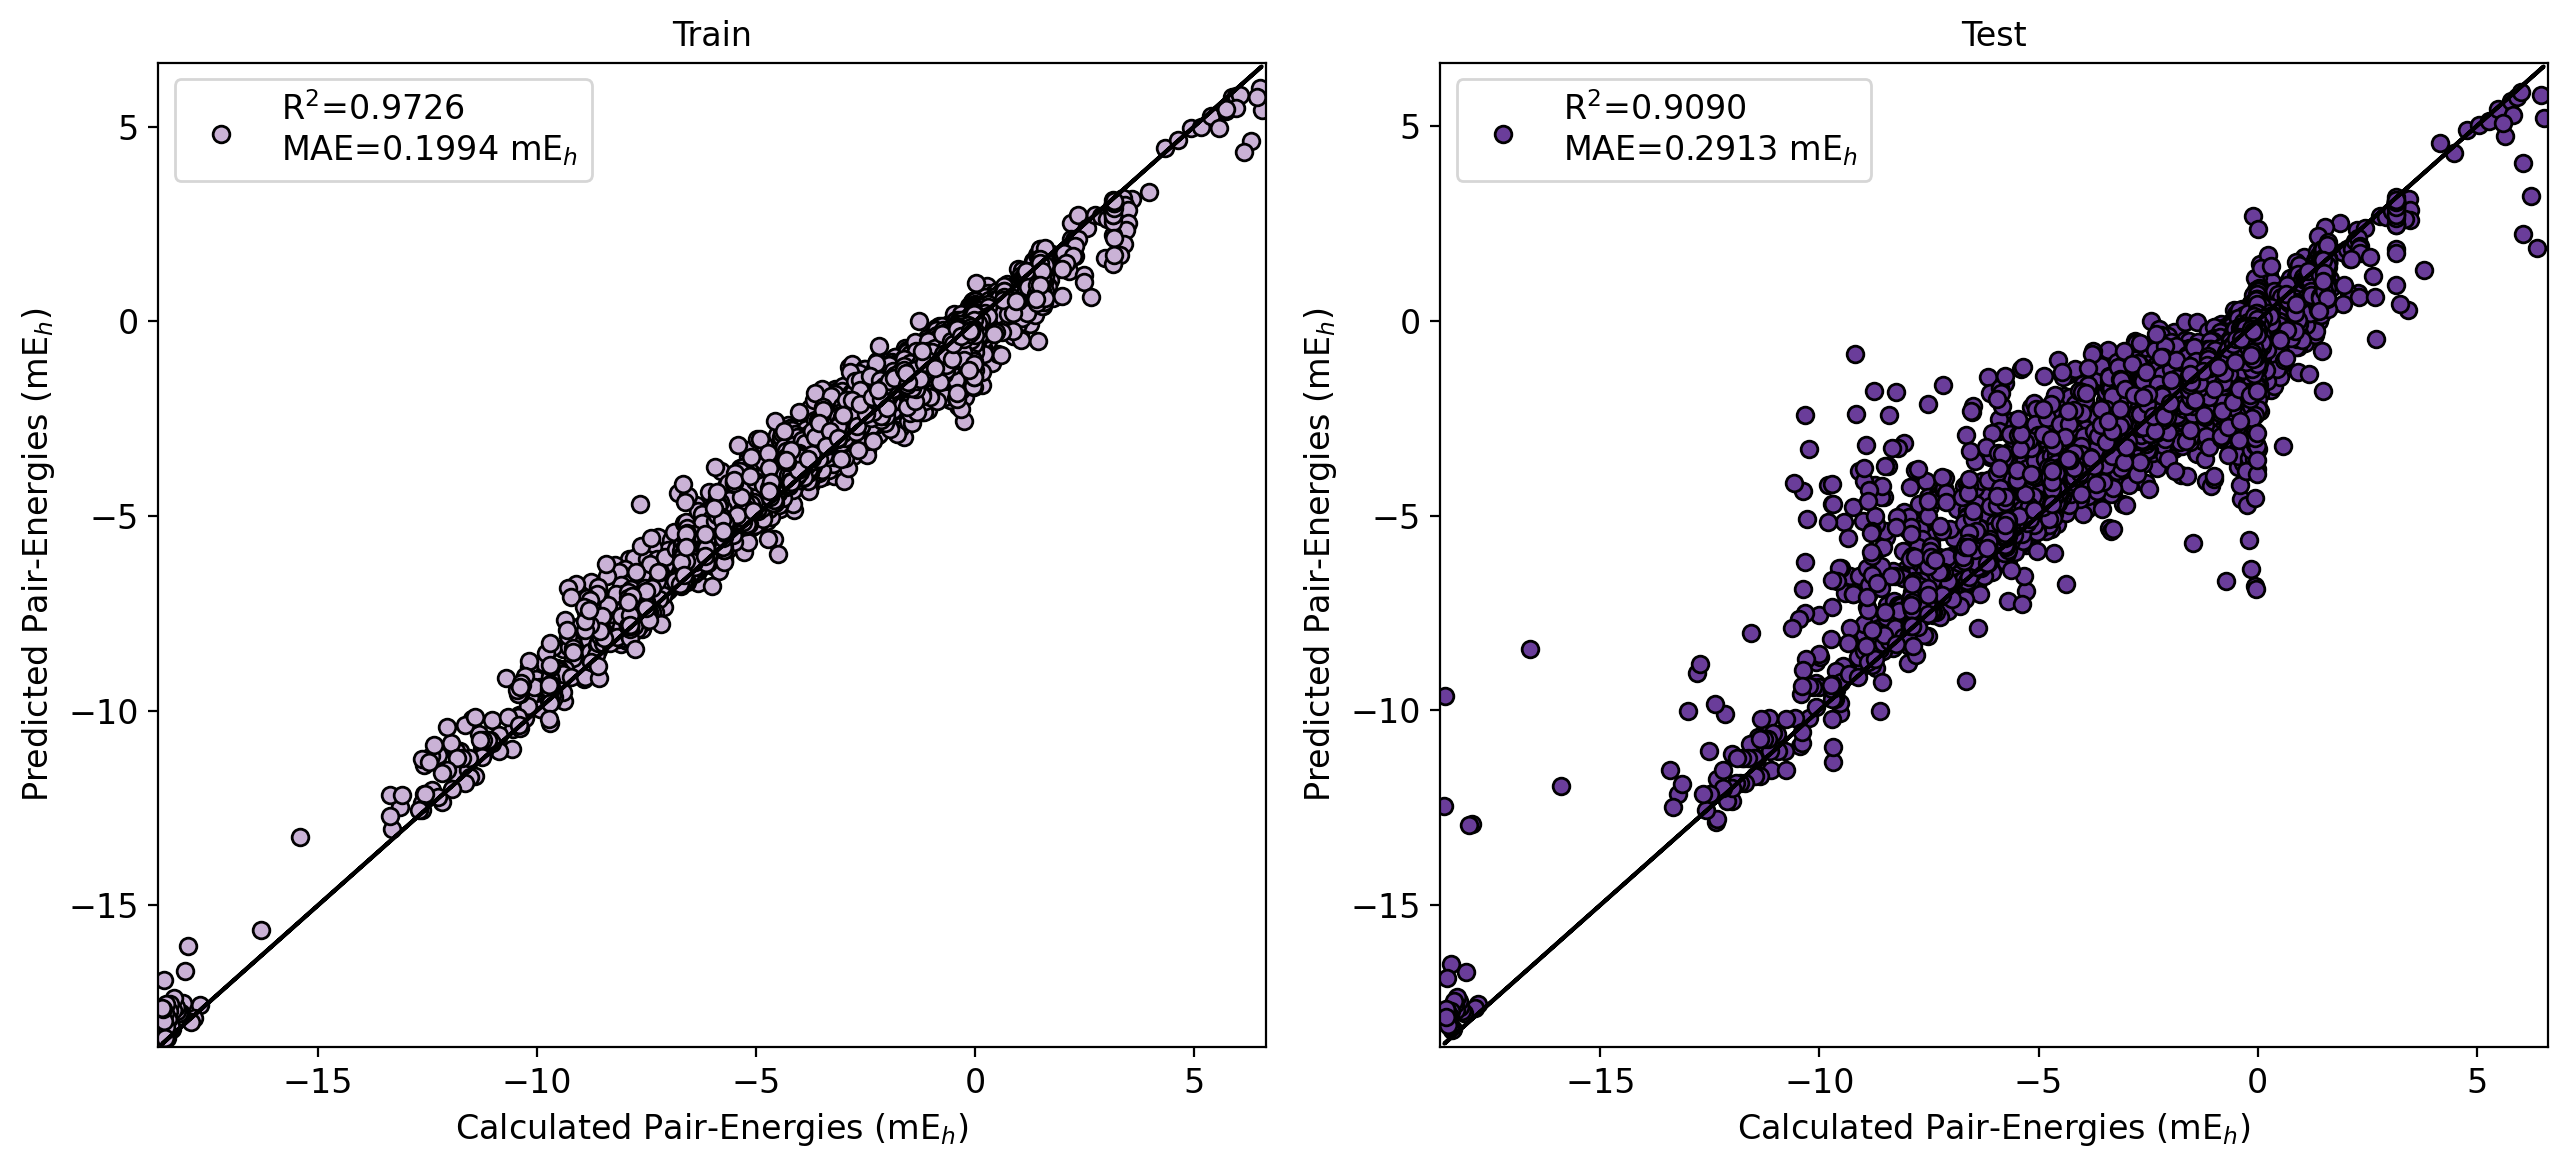

In [43]:
pal = sns.color_palette("Paired")
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.4f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$",color=pal[8],edgecolors='k')
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.4f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color=pal[9],edgecolors='k')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
plt.savefig('images/iron_VDZP_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [18]:
testcntrcvr = 0
recover_test_list = []
recover_test_E2 = []
for j,k,l in recover_test:
    init_test = testcntrcvr
    testcntrcvr+=l
    recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
    recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))


traincntrcvr = 0
recover_train_list = []
recover_train_E2 = []
for j,k,l in recover_train:
    init_train = traincntrcvr
    traincntrcvr+=l
    recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
    recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

In [19]:
traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
#.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
#.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})



traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
traincorrE2['E2']=np.zeros(len(traincorrE2))



for i in traincorrE2.index:
    energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
    traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values

traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']

traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)


testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
testcorrE2['E2']=np.zeros(len(testcorrE2))



for i in testcorrE2.index:
    energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
    testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values

testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']

testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

In [20]:
traincaspt2melt = traincorrE2.reset_index().melt(id_vars=['Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})
testcaspt2melt = testcorrE2.reset_index().melt(id_vars=['Radius ($\AA$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Radius ($\AA$)':float,'value':float})

In [21]:
trueE2=pd.concat([traincorrE2.reset_index(),testcorrE2.reset_index()]).astype({'Radius ($\AA$)':float,'E$_{\text{CASPT2}}^{\text{Calculated}}$':float})

In [22]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(6.207020359206581)

In [23]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(4.097128095504559)

In [24]:
pairedcp=sns.color_palette('Paired')

In [25]:
mean_absolute_error(traincorrE2['E$_{2}^{\text{Calculated}}$'],traincorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(4.096696171275342)

In [26]:
mean_absolute_error(testcorrE2['E$_{2}^{\text{Calculated}}$'],testcorrE2['E$_{2}^{\text{Predicted}}$'])*1e3

np.float64(6.206837909890728)

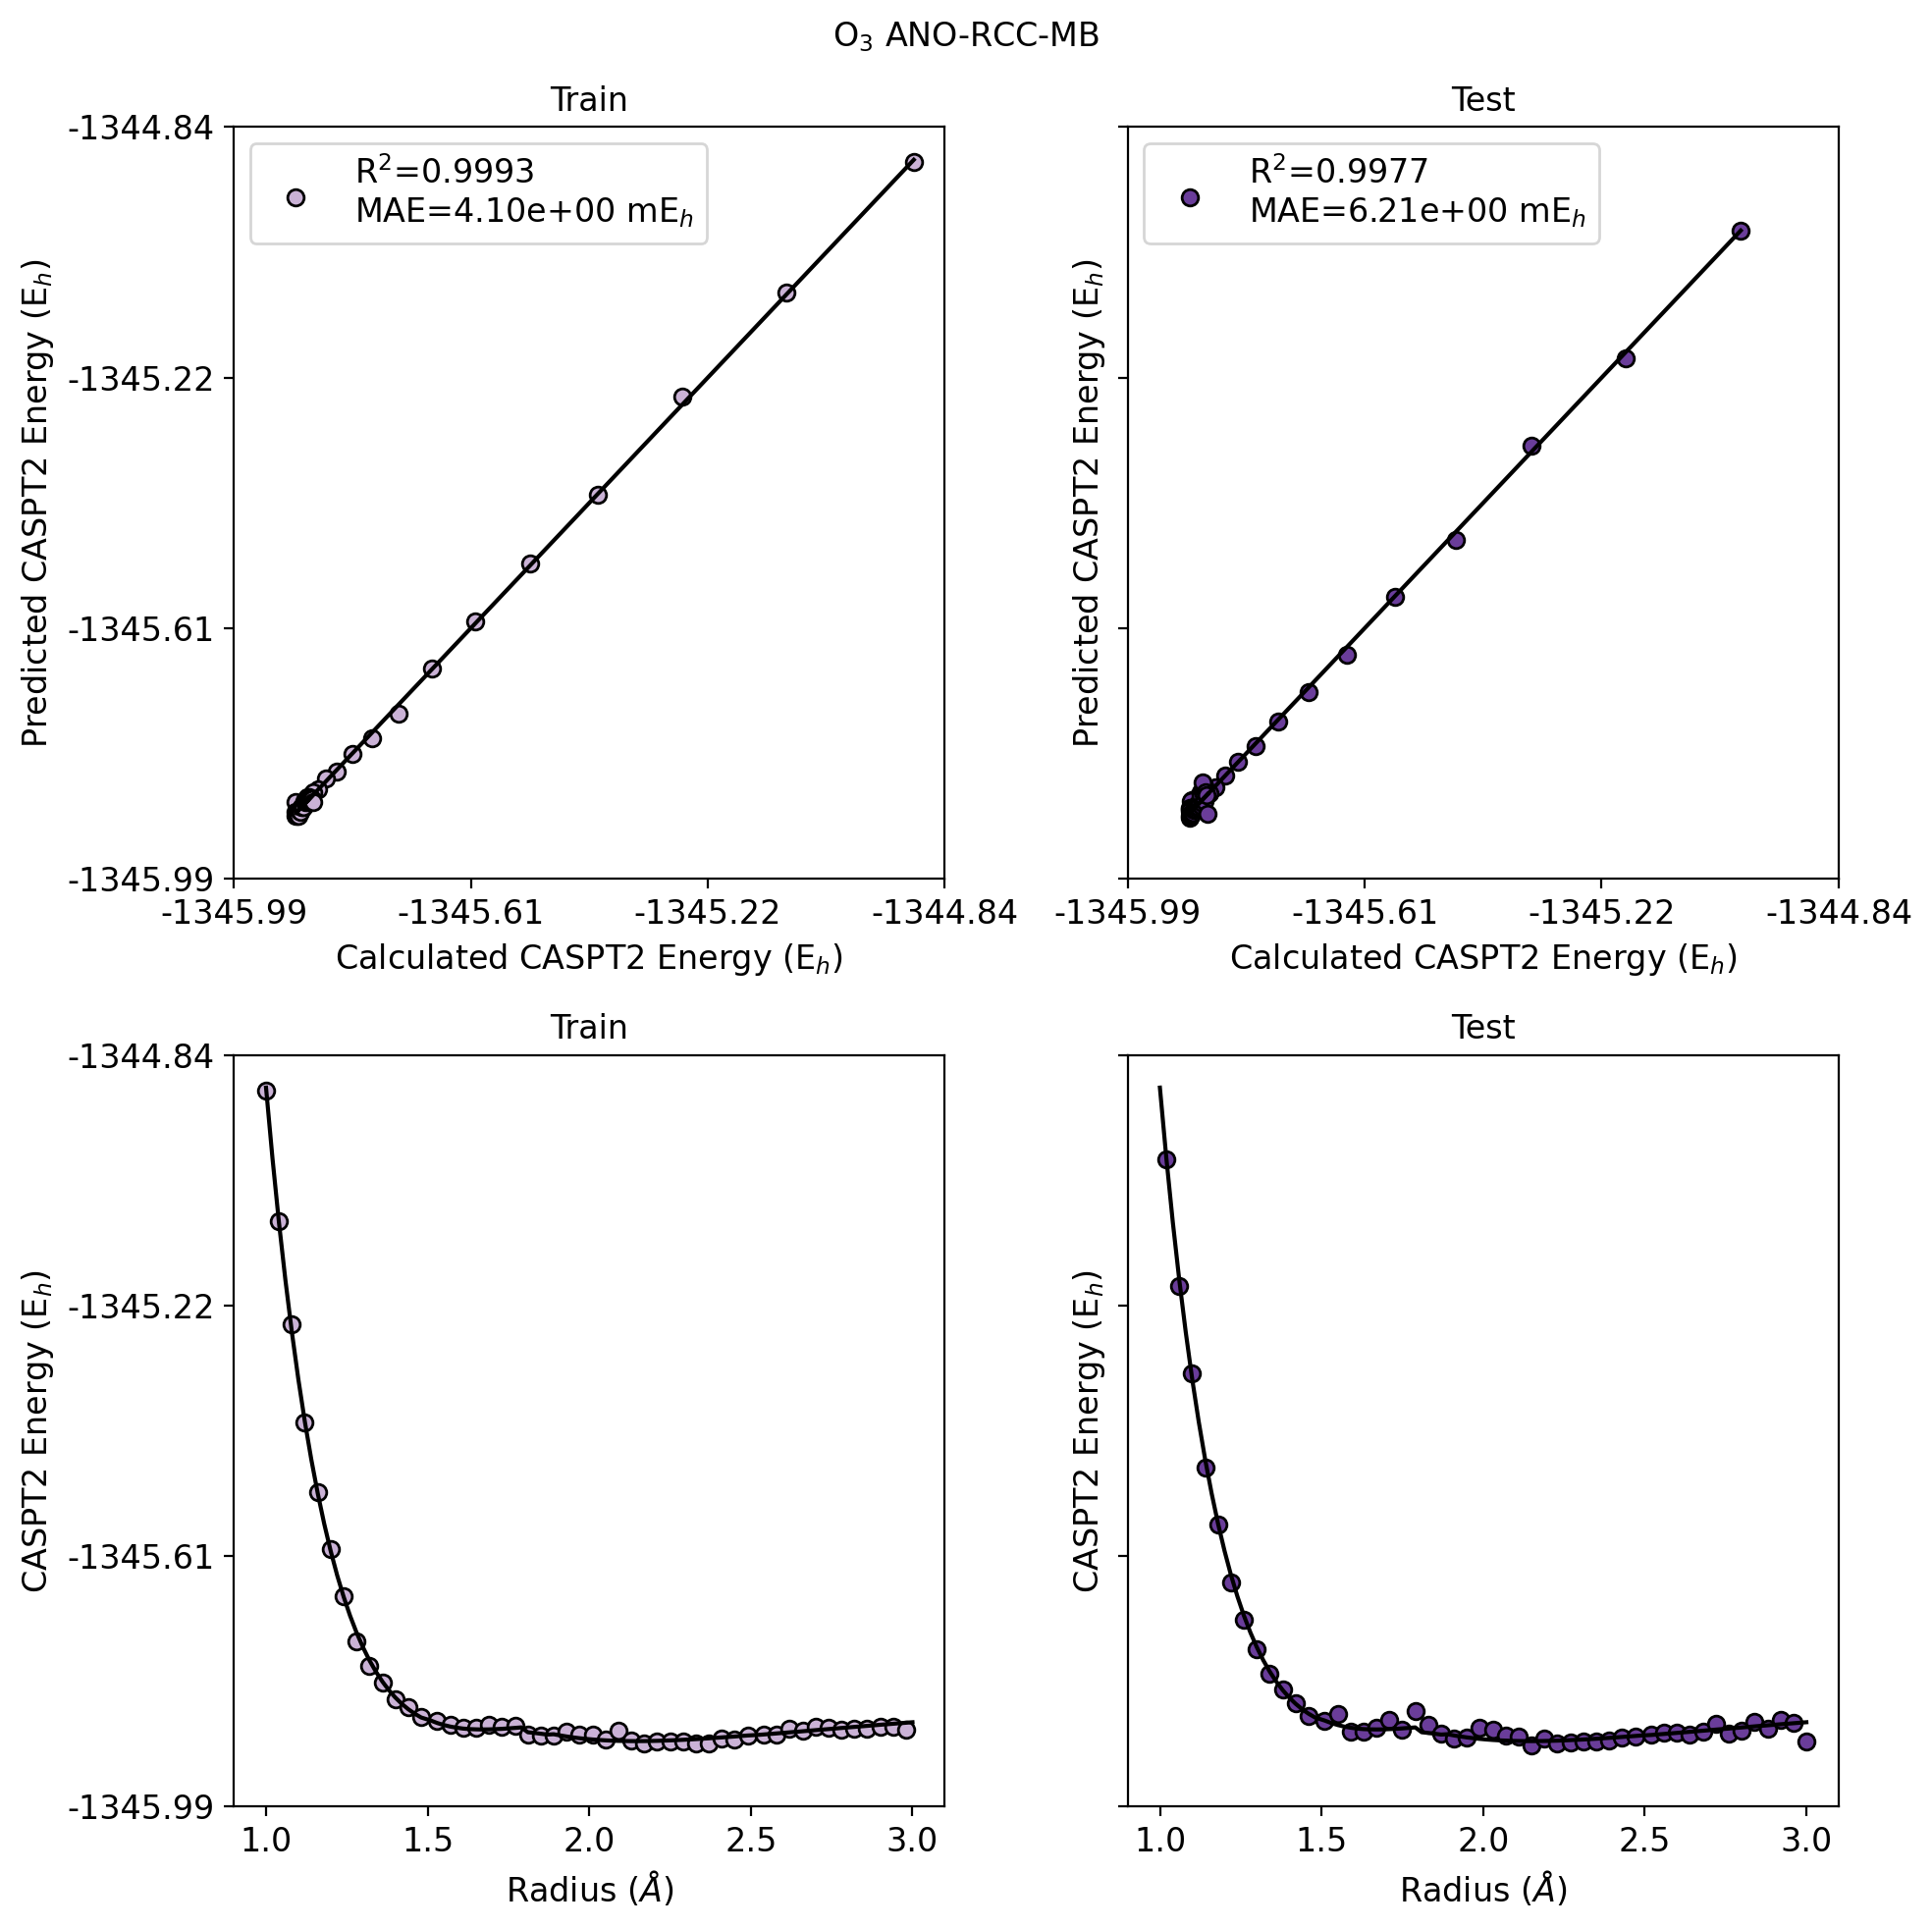

In [44]:
traincorrerr = {}

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=True)
traincorrE2 = traincorrE2.reset_index()
testcorrE2 = testcorrE2.reset_index()
pred_train,true_train = traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
pred_test,true_test = testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
testrad = testcorrE2['Radius ($\AA$)']    
train_r2_corr = r2_score(true_train,pred_train)
test_r2_corr = r2_score(true_test,pred_test)
test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)

traincorrerr = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
trainrad = traincorrE2['Radius ($\AA$)']


ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{train_r2_corr:.4f}\nMAE={train_mae_corr:.2e}'+" mE$_{h}$",color=pairedcp[8],edgecolors='k')
ax1.plot(true_train,true_train,'k')
ax1.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
ax1.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
ax1.set_title('Train')
ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax1.legend()


ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{test_r2_corr:.4f}\nMAE={test_mae_corr:.2e}'+" mE$_{h}$",color=pairedcp[9],edgecolors='k')
ax2.plot(true_test,true_test,'k')
ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax2.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
ax2.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
ax2.set_title('Test')    
ax2.legend()

ax3.scatter(np.array(trainrad,dtype=float),pred_train,color=pairedcp[8],edgecolors='k')
ax3.plot(trueE2.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2.sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
ax3.set_xlabel('Radius ($\AA$)')
ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
ax3.set_title('Train')

ax4.scatter(np.array(testrad,dtype=float),pred_test,color=pairedcp[9],edgecolors='k')
ax4.plot(trueE2.sort_values(by='Radius ($\AA$)')['Radius ($\AA$)'],trueE2.sort_values(by='Radius ($\AA$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'],'k')
ax4.set_xlabel('Radius ($\AA$)')
ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
ax4.set_title('Test') 


minpt2, maxpt2= pd.concat([true_train,true_test]).min(), pd.concat([true_train,true_test]).max()
pct=0.01
bufferbot, buffertop = minpt2*pct, maxpt2*pct


bottom, top = minpt2+-0.1, maxpt2+0.05

ax1.set_xlim(bottom,top)
ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
ax1.set_ylim(bottom,top)
ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_xlim(bottom,top)
ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_ylim(bottom,top)
ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    


ax3.set_ylim(bottom,top)
ax3.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)]) 

fig.suptitle("O$_{3}$ ANO-RCC-MB")

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.savefig(f'images/iron_VDZPCASPT2.png',dpi=300,bbox_inches='tight')
plt.show()    

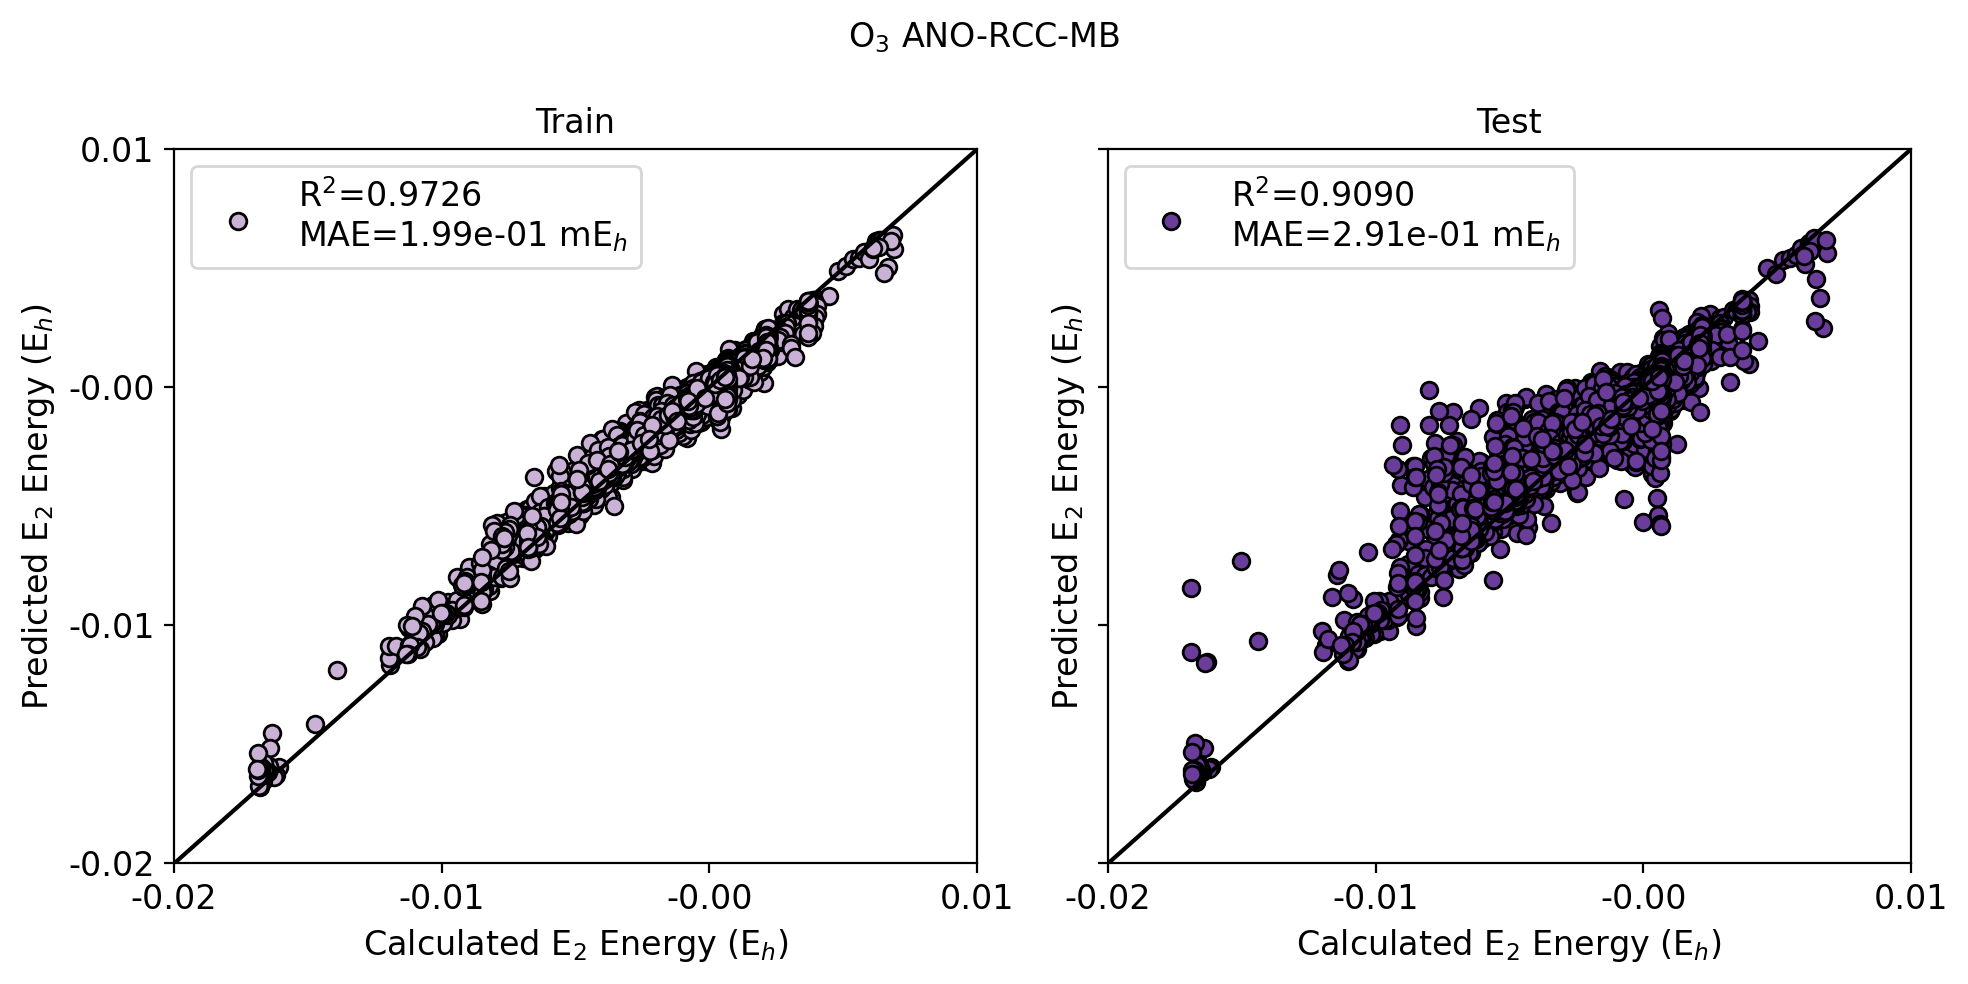

In [45]:
trainpairdf = pd.DataFrame(recover_train_list)
testpairdf = pd.DataFrame(recover_test_list)
pairerr={}

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

truetrainpair, predtrainpair = np.hstack(trainpairdf[1]),np.hstack(trainpairdf[2])
train_r2_pair = r2_score(truetrainpair, predtrainpair)
train_mae_pair = 1e3*mean_absolute_error(truetrainpair, predtrainpair)
ax1.scatter(truetrainpair, predtrainpair,label='R$^{2}$='+f'{train_r2_pair:.4f}\nMAE={train_mae_pair:.2e}'+" mE$_{h}$",color=pairedcp[8],edgecolors='k')
ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax1.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
ax1.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
ax1.set_title('Train')    
ax1.legend()  

truetestpair, predtestpair = np.hstack(testpairdf[1]),np.hstack(testpairdf[2])
test_r2_pair = r2_score(truetestpair, predtestpair)
test_mae_pair = 1e3*mean_absolute_error(truetestpair, predtestpair)
ax2.scatter(truetestpair, predtestpair,label='R$^{2}$='+f'{test_r2_pair:.4f}\nMAE={test_mae_pair:.2e}'+" mE$_{h}$",color=pairedcp[9],edgecolors='k')
ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax2.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
ax2.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
ax2.set_title('Test')    
ax2.legend()    

mincorr, maxcorr= np.hstack([truetrainpair,truetestpair]).min(), np.hstack([truetrainpair,truetestpair]).max()
pct=0.50
bufferbot, buffertop = mincorr*pct, maxcorr*pct

# if 'H' in n:
bottom, top = mincorr-buffertop, maxcorr+buffertop

# else:
#     bottom, top = mincorr+-0.1, maxcorr+0.05

ax1.set_xlim(bottom,top)
ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
ax1.set_ylim(bottom,top)
ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_xlim(bottom,top)
ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_ylim(bottom,top)
ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    

fig.suptitle("O$_{3}$ ANO-RCC-MB")
plt.tight_layout()
plt.savefig(f'images/iron_VDZPE2.png',dpi=300,bbox_inches='tight')    
plt.show()
pairerr = {"r2_train":train_r2_pair,"r2_test":test_r2_pair,"mae_train":train_mae_pair,"mae_test":test_mae_pair}

In [46]:
# meltcorrerr = pd.DataFrame.from_dict(traincorrerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
# meltpairerr = pd.DataFrame.from_dict(pairerr).loc[['mae_train','mae_test']].T.rename(columns={'mae_train':'Train','mae_test':'Test'}).reset_index().melt(id_vars=['index'], value_vars=['Train','Test'])
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
# sns.barplot(data=meltpairerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax1)
# ax1.set_ylabel('Mean Absolute Error (mE$_{h}$)')
# ax1.set_xlabel('Structures')
# ax1.set_title('Pair-Energies')
# ax1.set_ylim(0,2.5)
# sns.barplot(data=meltcorrerr,x='index',y='value',hue='variable',palette=pairedcp[4:6],ax=ax2)
# # ax2.set_ylabel('Mean Absolute Error (mE$_{h}$)')
# ax2.set_ylabel('')
# ax2.set_xlabel('Structures')
# ax2.set_title('Correlation Energies')

# plt.tight_layout()
# plt.savefig('images/MAE_bar.png',dpi=300,bbox_inches='tight')
# plt.show()

In [47]:
import shap
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)



PermutationExplainer explainer: 20801it [23:52, 14.41it/s]                                                                                                                                                         


In [48]:
dffeat=pd.DataFrame(shap_values.abs.values.mean(axis=0),index=train_df.drop(columns=['Pair_Energies']).columns,columns=['shap']).rename(index={'1':'$\mathbf{b}$'}).reset_index().rename(columns={'index':'feat'}).sort_index().sort_values(by=['shap','feat'],ascending=False)
# dffeat['rename']=len(dffeat)*[1]


In [49]:
[i for i in dffeat['feat'] if "_{q" in i ]

['$F_{q}^{\\text{SCF}}$',
 'h$_{q}$',
 '$\\omega_{q}$',
 '$F_{q}$',
 '$\\eta_{q}$',
 'FA$_{qs}$',
 'FI$_{qs}$',
 'h$_{qs}$',
 'F$_{qs}$']

In [50]:
with open('iron_VDZP_feature_names.txt','w') as f:
    for i in dffeat['feat'].values:
        f.write(i+'\n')

# with open('feature_names.txt','w') as f:
#     for i in dffeat['feat'].values:
#         f.write(i+'\n')

In [51]:
np.arange(0, dffeat['feat'].values.size, dffeat['feat'].values.size // 3),dffeat['feat'].values.size

(array([ 0, 35, 70]), 105)

In [52]:
dffeat.to_excel('iron_VDZP_SHAP.xlsx')

0 [0, 35]
1 [35, 70]
2 [70, 105]


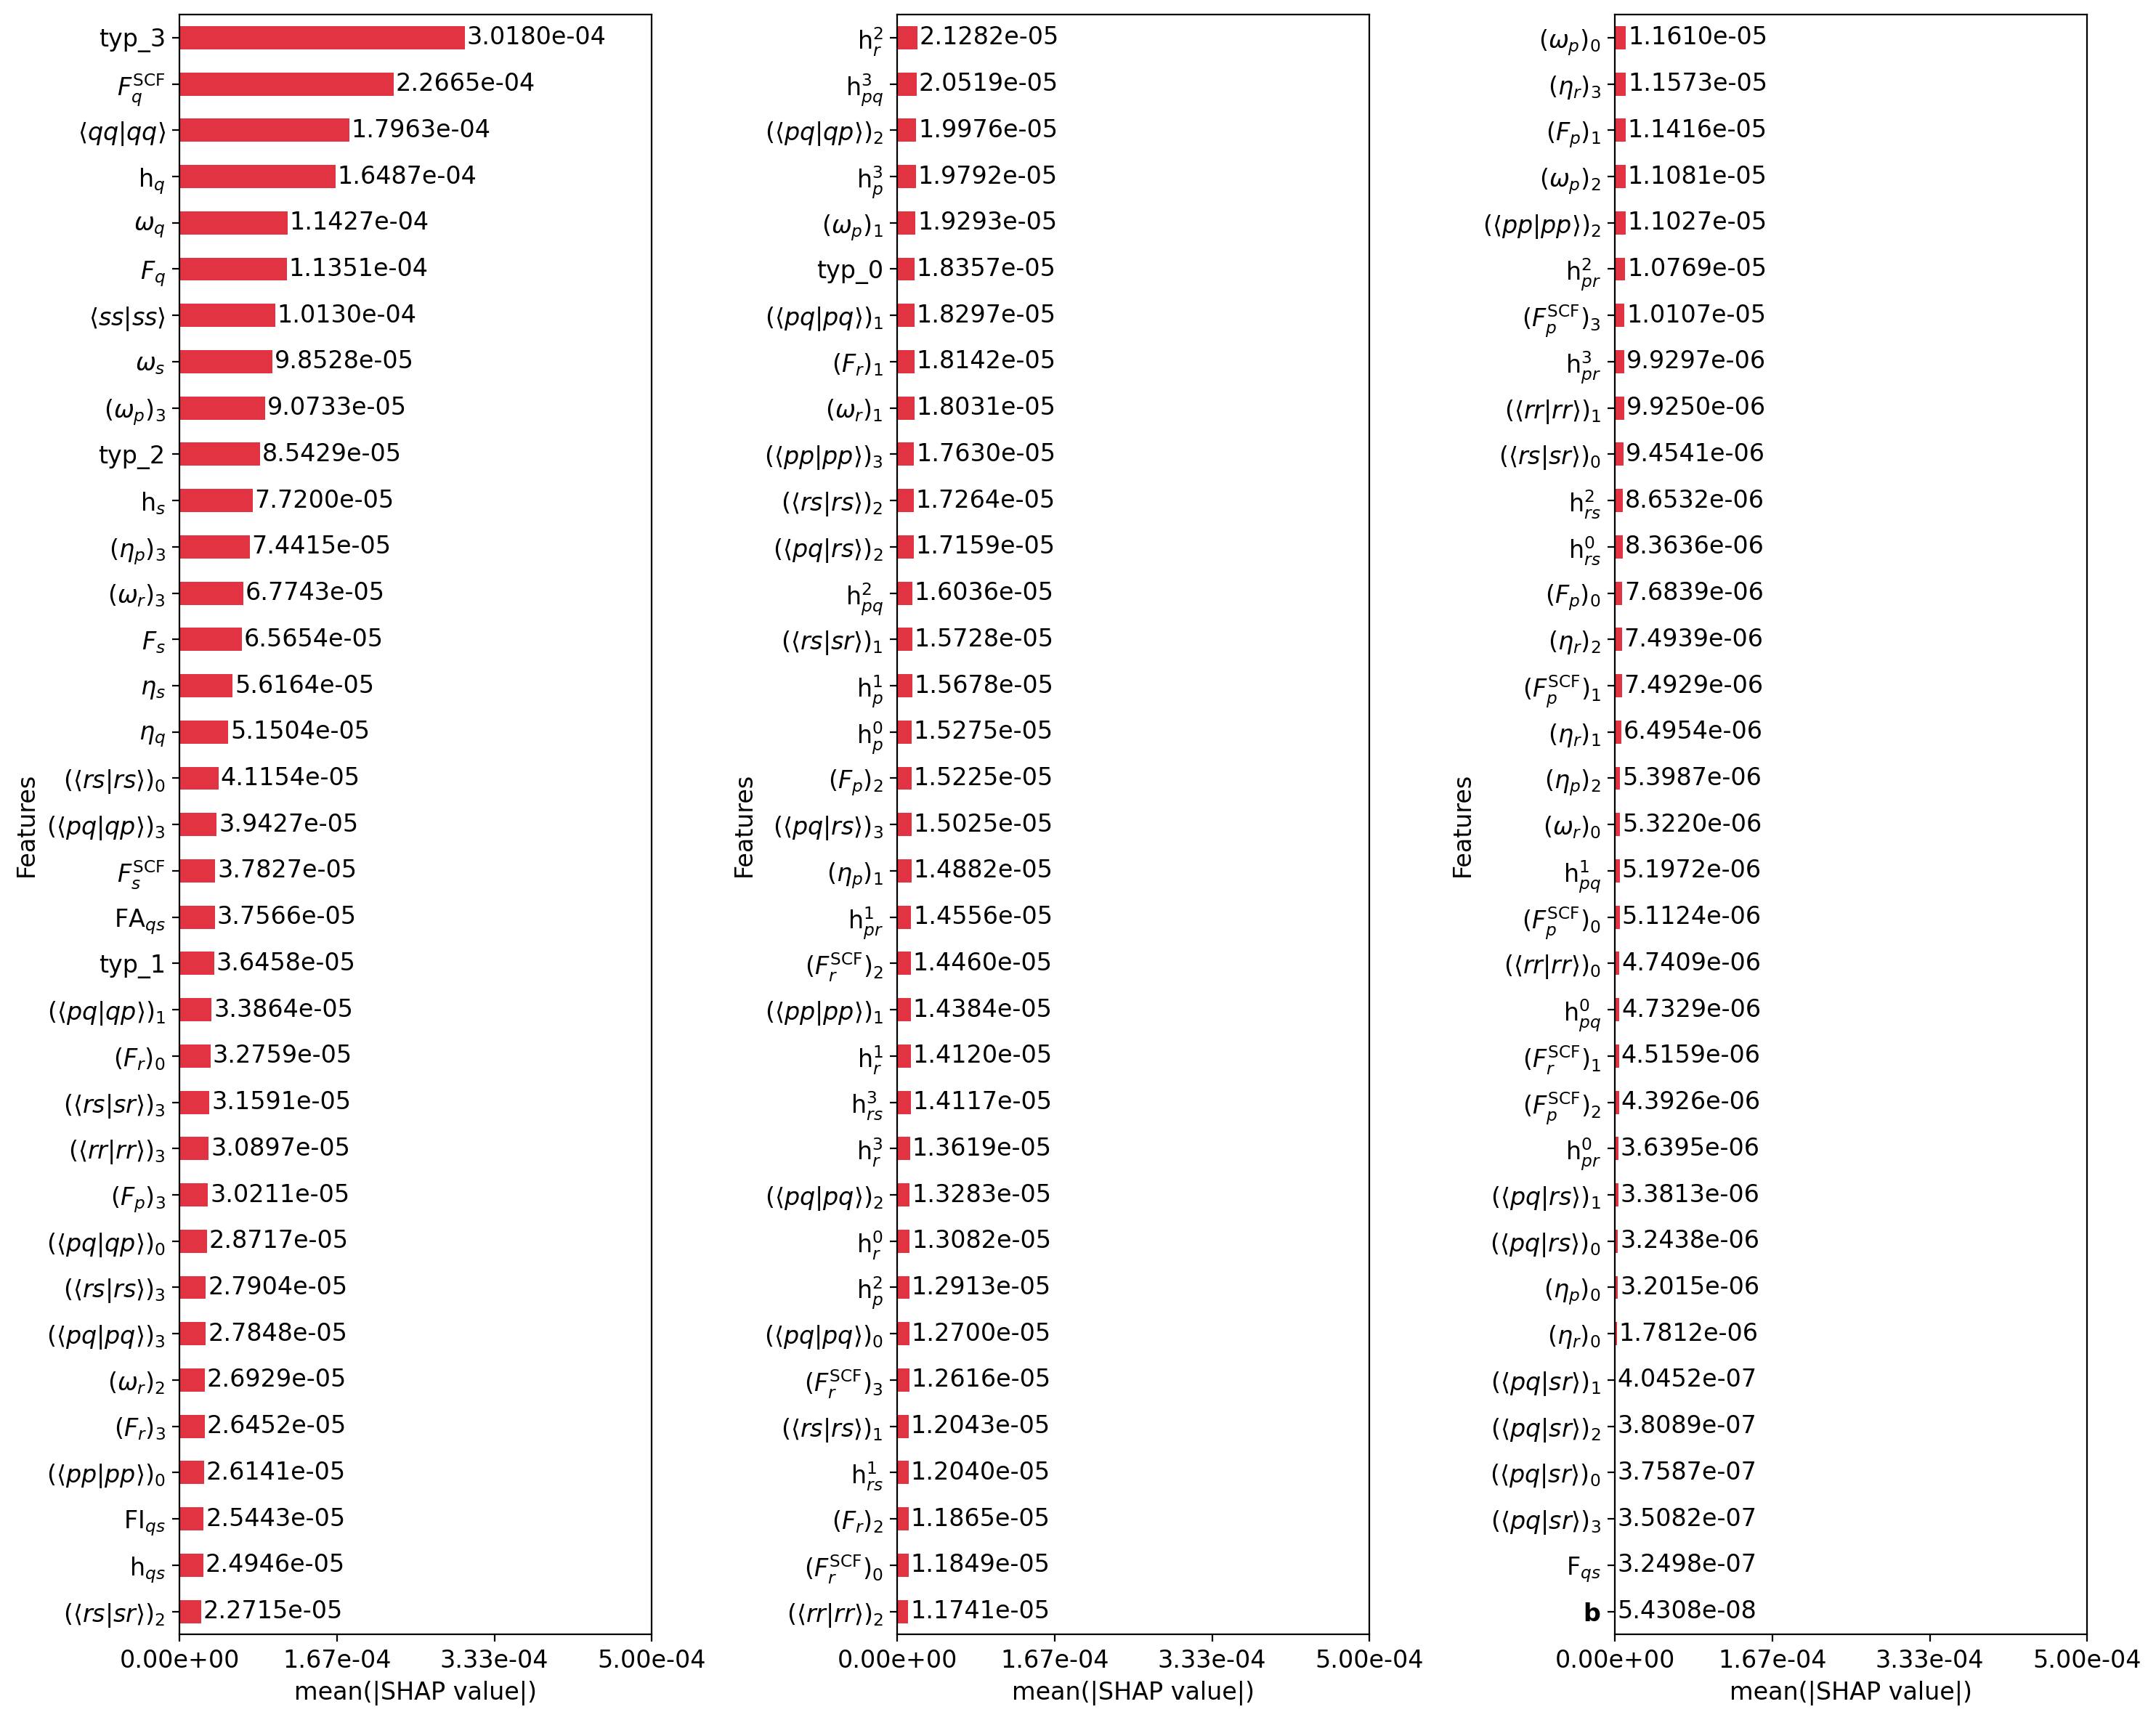

In [53]:
color_map=sns.color_palette('rocket',6)
fontsize = 12
fig, ax = plt.subplots(1,3,figsize=(15,12))
for idx, i in enumerate([[ 0,  35], [35,  70], [70, 105]]):
    print(idx,i)
    feat_1 = dffeat.iloc[i[0]:i[1]]
    ax[idx]=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax[idx])
    ax[idx].bar_label(ax[idx].containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
    ax[idx].set_xlim(0,5e-4)
    ax[idx].set_xticks(np.linspace(0,5e-4,4),[f"{i:.2e}" for i in np.linspace(0,5e-4,4)])
    ax[idx].set_ylabel('Features',fontsize=fontsize)
    ax[idx].set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

fig.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.savefig('images/iron_VDZP_shap_bar.png',dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# # plt.figure(figsize=(8,13))
# color_map=sns.color_palette('rocket',6)
# fontsize = 5

# feat_2 = dffeat.sort_values(by=['shap','feat']).iloc[:63]
# feat_1 = dffeat.sort_values(by=['shap','feat']).iloc[63:]


# ax1=feat_1.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax1)
# ax1.bar_label(ax1.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax1.set_xlim(0,5e-4)
# ax1.set_xticks(np.linspace(0,5e-4,4),[f"{i:.4f}" for i in np.linspace(0,5e-4,4)])
# ax1.set_ylabel('Features',fontsize=fontsize)
# ax1.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# ax2=feat_2.sort_values(by=['shap','feat']).plot.barh(x='feat',y='shap',legend=False,color=color_map[3],fontsize=fontsize,ax=ax2)
# ax2.bar_label(ax2.containers[0], fmt='%.4e',fontsize=fontsize,padding=1)
# ax2.set_xlim(0,5e-4)
# ax2.set_xticks(np.linspace(0,5e-4,4),[f"{i:.4f}" for i in np.linspace(0,5e-4,4)])
# ax2.set_ylabel('')
# ax2.set_xlabel('mean(|SHAP value|)',fontsize=fontsize)

# plt.tight_layout()
# # os.mkdir('images')
# plt.savefig('images/Hn_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()



In [55]:
r2_score(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9993386665254047

In [56]:
r2_score(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])

0.9976795440090732

In [57]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(4.097128095504559)

In [58]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(6.207020359206581)